# Usage

In [3]:
nbsphinxStation
import hydrodata.datasets as hds
from hydrodata import plot

Hydrodata module downloads daily climate data for a USGS station based its ID or coordinates (longitude and latitude). It requires at least three parameters: start date, end date and USGS station ID or coordinates. The data are downloaded from the [Daymet](https://daymet.ornl.gov/) and [NWIS](https://nwis.waterdata.usgs.gov/nwis) datasets.

## Climate Data

For example, let's consider the following USGS station:

In [4]:
station_id = '01031500'
start, end = '2000-01-01', '2010-01-21'

Now, we can define an instance based on the station coordinate. Upon instantiation, the station and its watershed characteristics are found using [NLDI](https://labs.waterdata.usgs.gov/about-nldi/) service.

In [5]:
piscataquis = Station(start, end, station_id=station_id, data_dir="examples/data")

[ID: 01031500] Downloading upstream tributaries from NLDI >>> finished.
[ID: 01031500] Downloading upstream main from NLDI >>> finished.
[ID: 01031500] Downloading flowlines by ComIDs from NLDI >>> finished.
[ID: 01031500] Watershed: Piscataquis River near Dover-Foxcroft, Maine
               Coordinates: (-69.315, 45.175)
               Altitude: 109 m above NGVD29
               Drainage area: 774 sqkm.


We the retrieved information such as the watershed geometry we can use the `datasets` module to access other databases. For example, we can find the USGS station upstream of the main river channel up to a certain distance, say 150 km. Also, all the USGS stations inside the watershed can be found.

[ID: 01031500] Downloading all the stations upstream tributaries from NLDI >>> finsihed.
[ID: 01031500] Downloading stations within 150 km of upstream main from NLDI >>> finsihed.


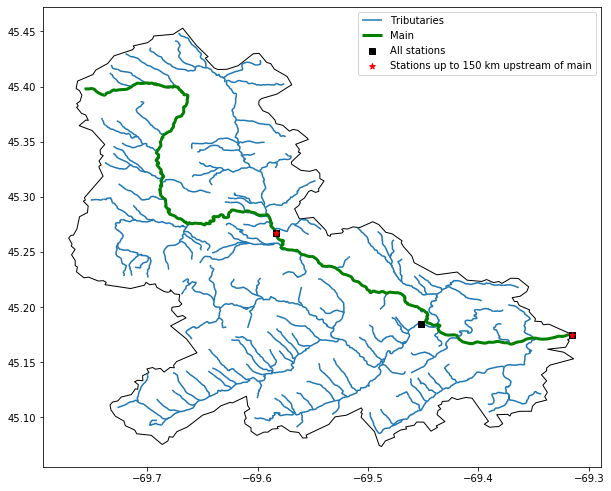

In [6]:
stations = piscataquis.watershed.get_stations()
stations_upto_150 = piscataquis.watershed.get_stations(navigation="upstreamMain", distance=150)

ax = piscataquis.watershed.basin.plot(color='white', edgecolor='black', zorder=1, figsize = (10, 10))
piscataquis.tributaries.plot(ax=ax, label='Tributaries', zorder=2)
piscataquis.main_channel.plot(ax=ax, color='green', lw=3, label='Main', zorder=3)
stations.plot(ax=ax, color='black', label='All stations', marker='s', zorder=4)
stations_upto_150.plot(ax=ax, color='red', label='Stations up to 150 km upstream of main', marker='*', zorder=5)
ax.legend(loc='best');

Next, let's get the Digital Elevation Model of the watershed from [OpenTopography](https://opentopography.org/) service.

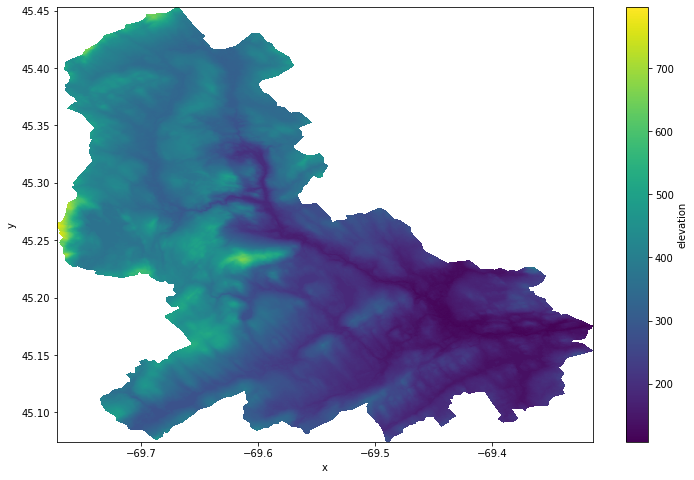

In [7]:
piscataquis_dem = hds.dem_bygeom(piscataquis.geometry)
piscataquis_dem.plot(size=8);

The climate and streamflow observations data can be retrieved for the location of interest:

In [8]:
piscataquis_clm = hds.deymet_byloc(piscataquis.lon, piscataquis.lat, start=piscataquis.start, end=piscataquis.end)
piscataquis_clm['Q (cms)'] = hds.nwis(piscataquis.station_id, piscataquis.start, piscataquis.end)
piscataquis_clm.head()

[LOC: (-69.31, 45.17)] Downloading climate data from Daymet >>> finished.
[ID: 01031500] Downloading stream flow data from NWIS >>> finished.


dayl (s)  prcp (mm/day)  srad (W/m^2)  swe (kg/m^2)  \
2000-01-01  31104.000000            0.0    185.600006          76.0   
2000-01-02  31104.000000            0.0    182.399994          76.0   
2000-01-03  31104.000000            3.0    121.599998          76.0   
2000-01-04  31104.000000            6.0    147.199997          72.0   
2000-01-05  31449.599609           13.0    128.000000          88.0   

            tmax (deg c)  tmin (deg c)  vp (Pa)   Q (cms)  
2000-01-01          -6.0         -17.0    160.0  5.974855  
2000-01-02          -0.5         -11.5    240.0  5.606736  
2000-01-03           5.5          -4.0    440.0  5.295250  
2000-01-04           8.5          -4.0    440.0  4.898814  
2000-01-05           3.0          -6.5    360.0  5.097032

In addition to point-based data, gridded data can also be accessed. For example, let's get the climate data for the whole watershed. The `daymet_bygeom` function can also compute Potential EvapoTranspiration using FAO-56.

In [9]:
variables = ["tmin", "tmax", "prcp"]
piscataquis_grd = hds.daymet_bygeom(piscataquis.geometry, start='2005-01-01', end='2005-01-31', variables=variables, pet=True)

[CNT: (-69.58, 45.24)] Downloading climate data from Daymet >>> finished.
[CNT: (-69.58, 45.24)] Computing PET >>> finished.


The data is returned as an `xarray` dataset which provides access to many exploratory features. It's noteworthy that Daymet data projection is Lambert Conformal thus for plotting purposes it should be considered.

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Daymet data projection
lcc = ccrs.LambertConformal(standard_parallels=(25, 60), central_longitude=-100, central_latitude=42.5)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
cax = fig.add_axes([ax.get_position().x1 + 0.14, ax.get_position().y0, 0.02, ax.get_position().height])
piscataquis_grd.isel(time=1).tmin.plot(ax=ax, transform=lcc, cbar_kwargs={"cax":cax});

Access to actual EvapoTranspiration data through [SSEBop](https://earlywarning.usgs.gov/ssebop/modis/daily) is also possible. However, since there's still no web service available for subsetting the data, `ssebopeta_bygeom` first downloads the data for the requested period then subsets the data based on the provided geometry locally. Therefore, it's not as fast as other function and the bottleneck is download speed which could vary depending on the available internet speed.

[CNT: (-69.58, 45.24)] Staging actual ET data from SSEBop:
31 files have already been downloaded.
[CNT: (-69.58, 45.24)] Proccessing the 31 downloaded file for the requested region >>> finished.


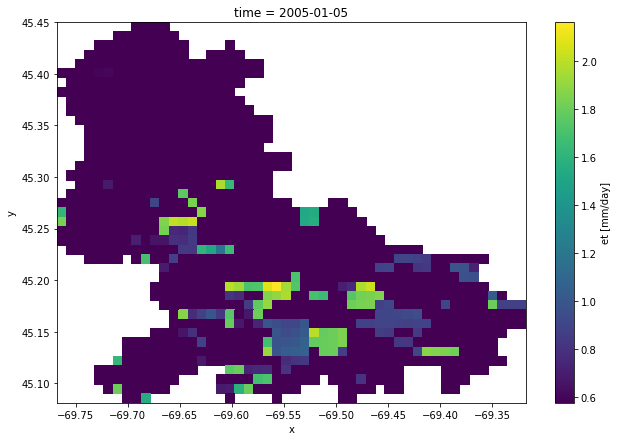

In [9]:
piscataquis_eta = hds.ssebopeta_bygeom(piscataquis.geometry, start='2005-01-01', end='2005-01-31')
piscataquis_eta.isel(time=4).et.plot(size=8);

Another database that is accessible is land use, land cover data though Multi-Resolution Land Characteristics (MRLC) Consortium. By default the data are downloaded from NLCD 2016.

In [11]:
piscataquis_lulc = hds.NLCD(piscataquis.geometry,
                            years={'impervious': 2016, 'cover': 2016, 'canopy': 2016},
                            data_dir=f"examples/data/{piscataquis.station_id}")

[CNT: (-69.58, 45.24)] Connecting to MRLC Web Map Service >>> connected.
[CNT: (-69.58, 45.24)] Downloading canopy data from NLCD 2016 database >>> finished.
[CNT: (-69.58, 45.24)] Downloading cover data from NLCD 2016 database >>> finished.
[CNT: (-69.58, 45.24)] Downloading impervious data from NLCD 2016 database >>> finished.


In addition to the downloaded raster files, some statistics on the data is performed and the result is returned as a dictionary. For example, let's get the percentages of each cover category.

In [12]:
piscataquis_lulc['cover']['categories']

{'Unclassified': 48.870984299516905,
 'Water': 1.173671497584541,
 'Developed': 1.786473429951691,
 'Barren': 0.036624396135265705,
 'Forest': 37.79695048309179,
 'Shrubland': 0.14230072463768115,
 'Herbaceous': 0.09740338164251208,
 'Planted/Cultivated': 0.7592391304347825,
 'Wetlands': 4.236624396135266}

The downloaded raster files can be plotted using [rasterio](https://rasterio.readthedocs.io/en/latest/). Hydrodata also provides a helper function for getting the official [legends](https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend) for the land cover dataset.

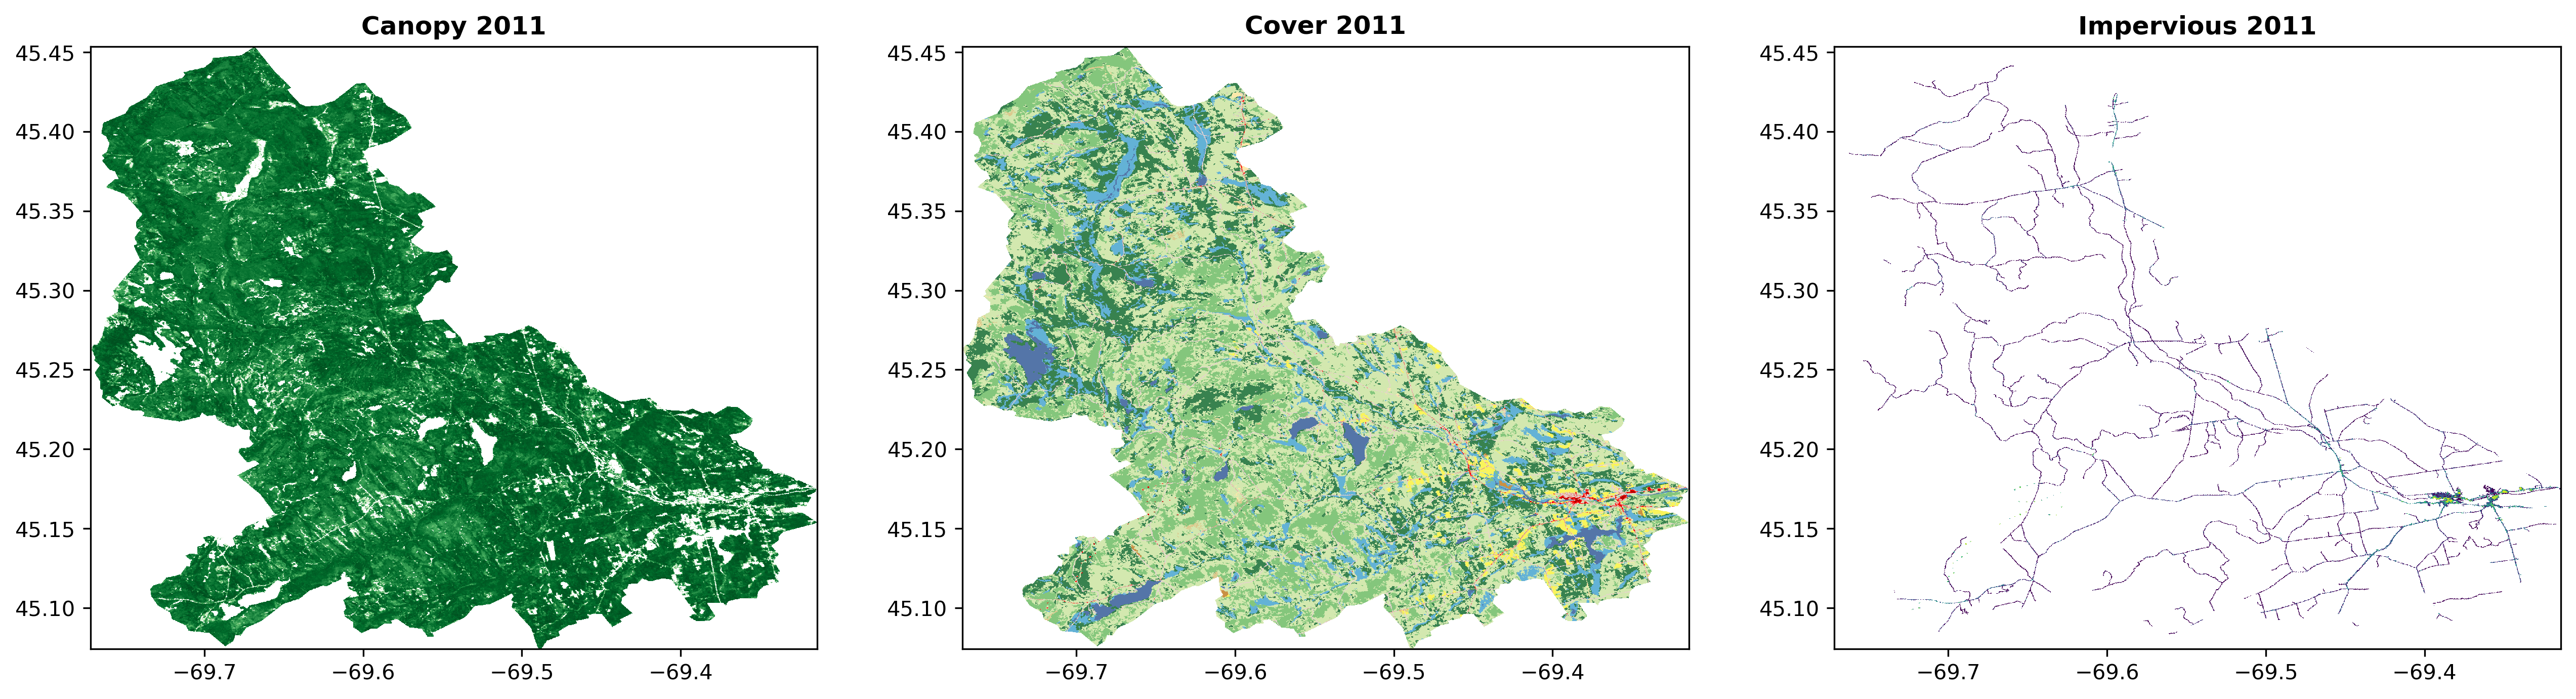

In [14]:
import rasterio
from rasterio.plot import show

cmap, norm = plot.cover_lenegeds()

rs = [rasterio.open(f"examples/data/{piscataquis.station_id}/{d}_2016.geotiff") for d in ['canopy', 'cover', 'impervious']]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7), dpi=300)
show(rs[0], ax=ax1, title=f'Canopy 2011', cmap='Greens')
show(rs[1], ax=ax2, title=f'Cover 2011', cmap=cmap, norm=norm)
show(rs[2], ax=ax3, title=f'Impervious 2011');

Moreover, longitude and latitude coordinate can also be used for downloading the data. The coordinates doesn't have to be exact since the closest station to the specified coordinates is found automatically. For example, let's find the climate data for a station close to the following coordinates:

In [15]:
lon, lat = -75.097, 40.016
frankford = Station(start, end, coords=(lon, lat), data_dir="examples/data")
frankford_Q = hds.nwis(frankford.station_id, frankford.start, frankford.end)

[ID: 01467087] Downloading upstream tributaries from NLDI >>> finished.
[ID: 01467087] Downloading upstream main from NLDI >>> finished.
[ID: 01467087] Downloading flowlines by ComIDs from NLDI >>> finished.
[ID: 01467087] Downloading watershed geometry using NLDI service >>>
[ID: 01467087] The watershed geometry saved to docs/examples/data/01467087/geometry.gpkg.
[ID: 01467087] Watershed: Frankford Creek at Castor Ave, Philadelphia, PA
               Coordinates: (-75.097, 40.016)
               Altitude: 5 m above NGVD29
               Drainage area: 81 sqkm.
[ID: 01467087] Downloading stream flow data from NWIS >>> finished.


## Plotting

The hydrologic signatures can be plotted easily using the `signatures` function from the `plot` module. This functions convert the streamflow data from cubic meter per second to millimeter per day based on the watershed area which should be provided in km$^2$.

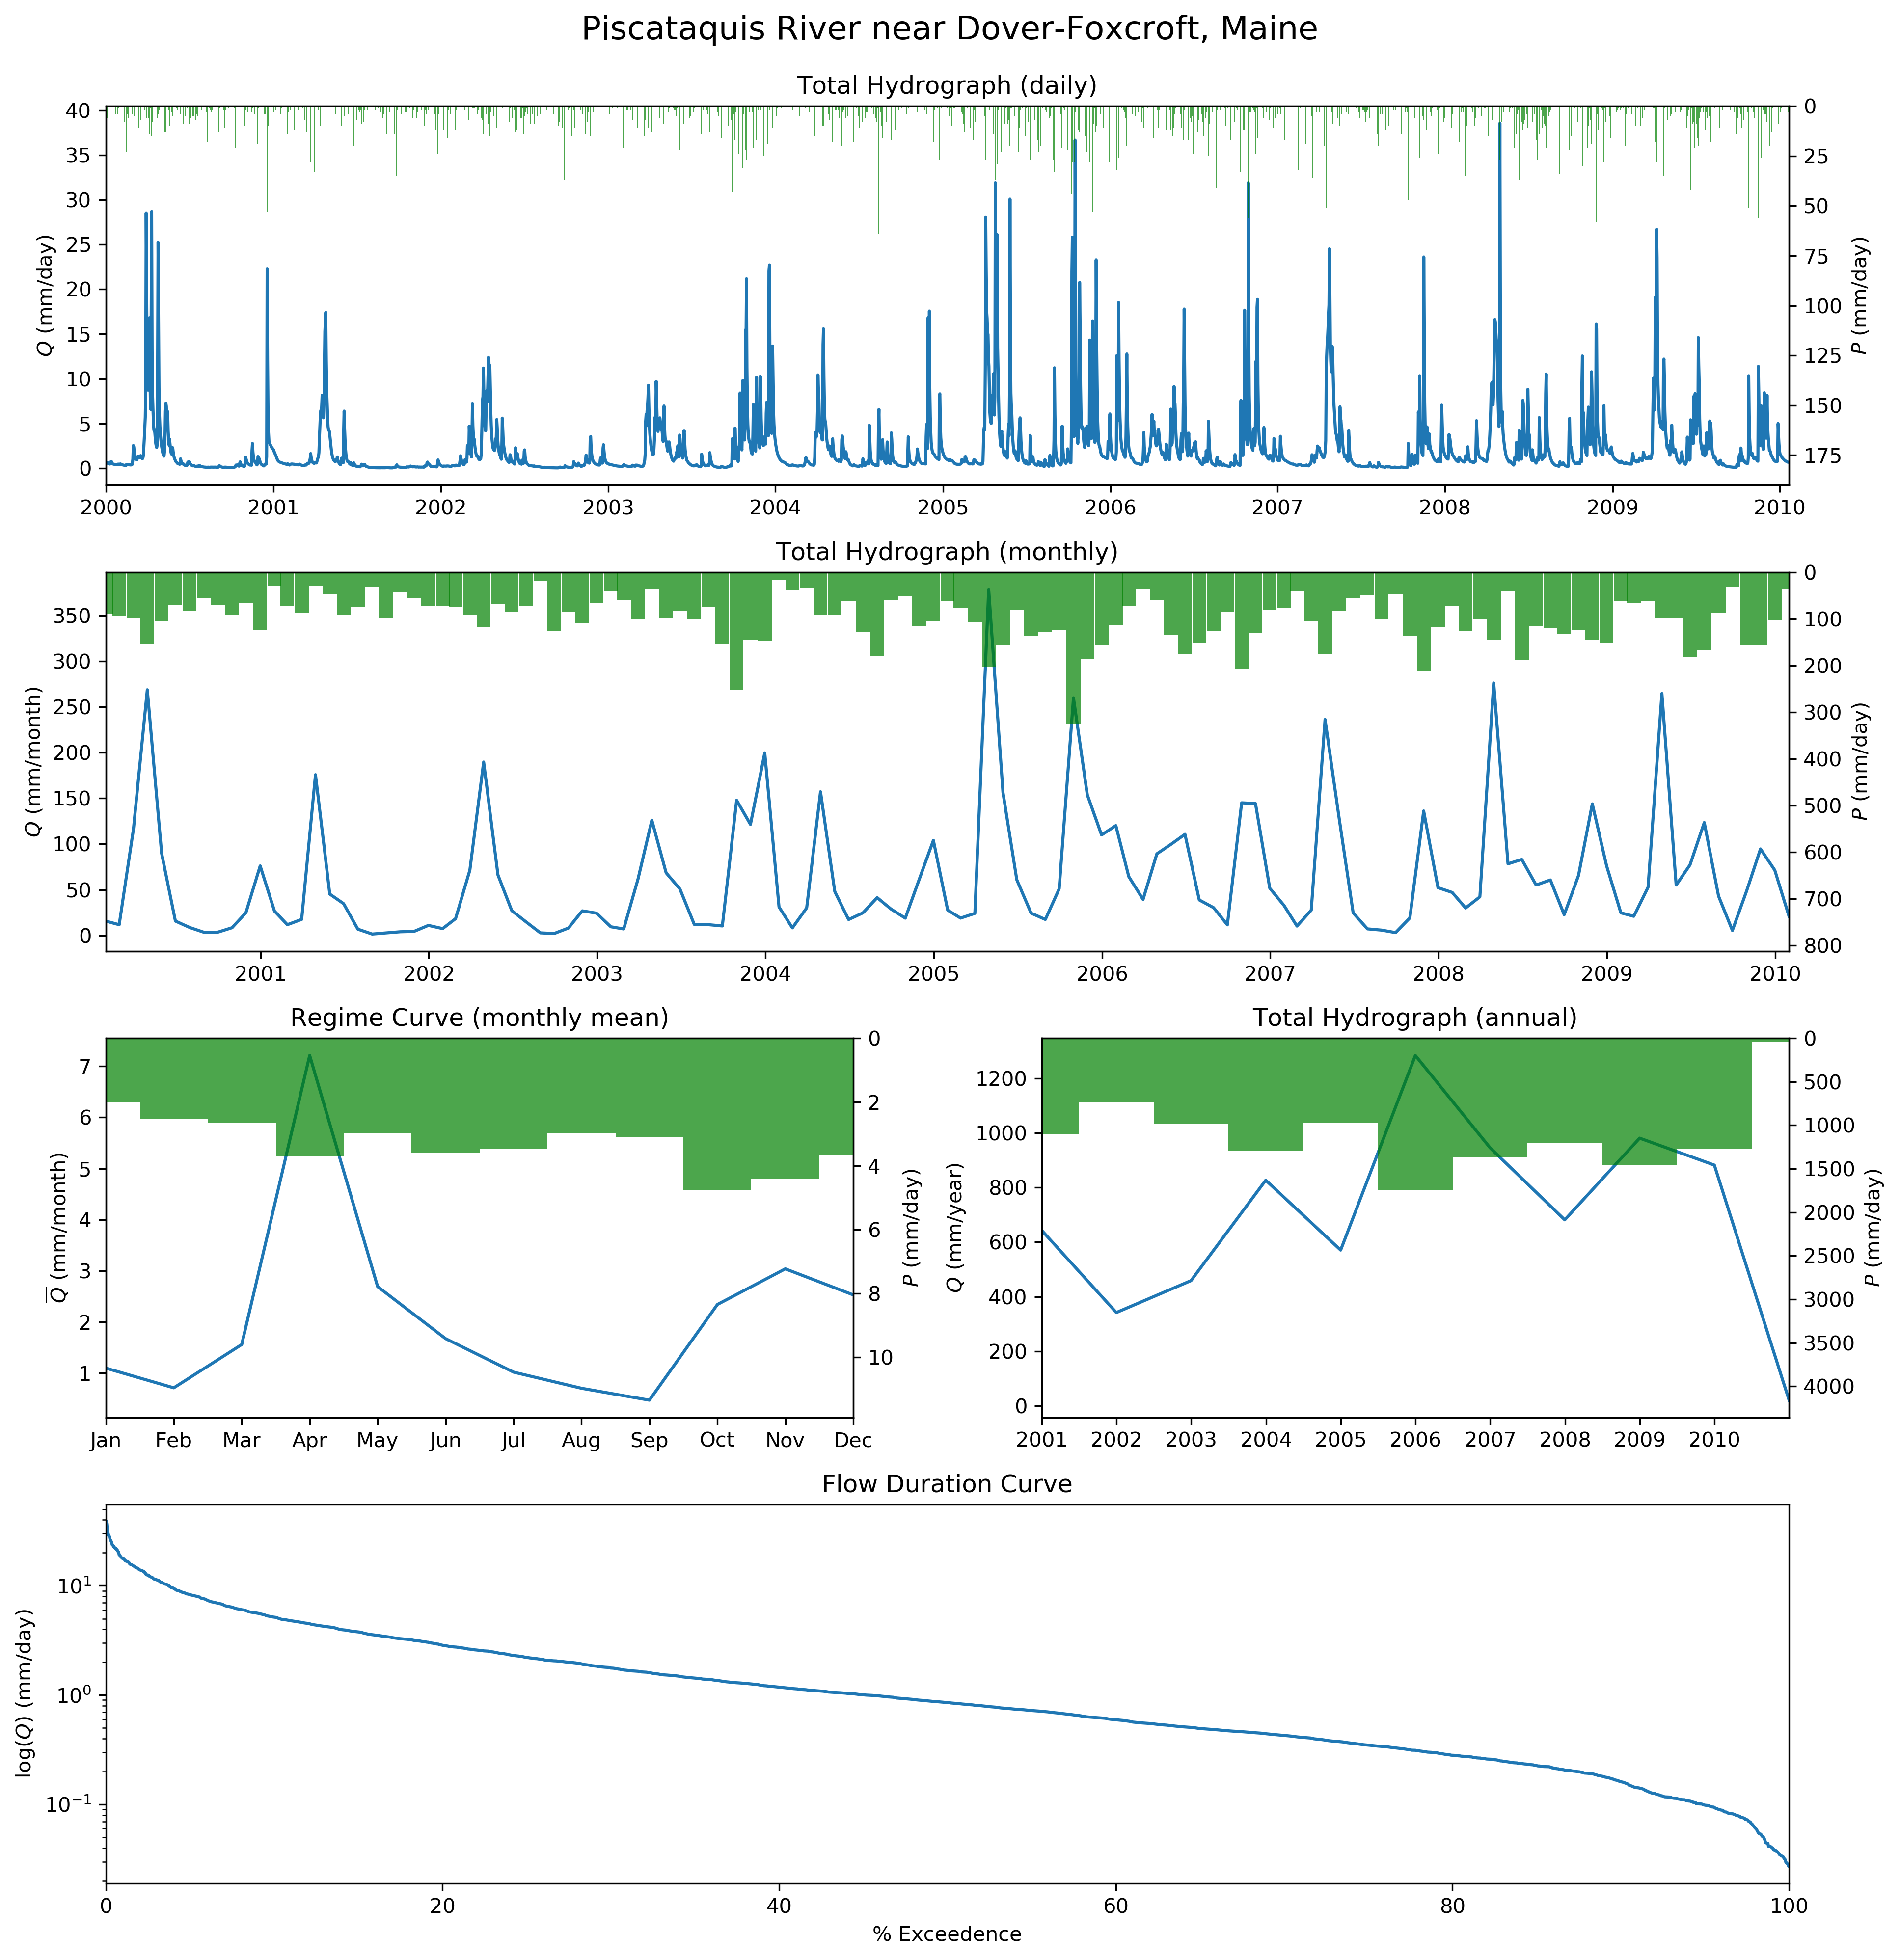

In [16]:
plot.signatures({'Piscataquis': (piscataquis_clm['Q (cms)'], piscataquis.drainage_area)},
                prcp=piscataquis_clm['prcp (mm/day)'],
                title=piscataquis.name)

### Observed discharge for multiple stations

The `plot_discharge` function can be used to compare hydrological signatures of multiple daily discharges time series of multiple stations. This plot doesn't include the precipitation data and only compares the discharges. Let's compare the Frankford and Fishing watershed. The discharge dictionary should be provided as before.

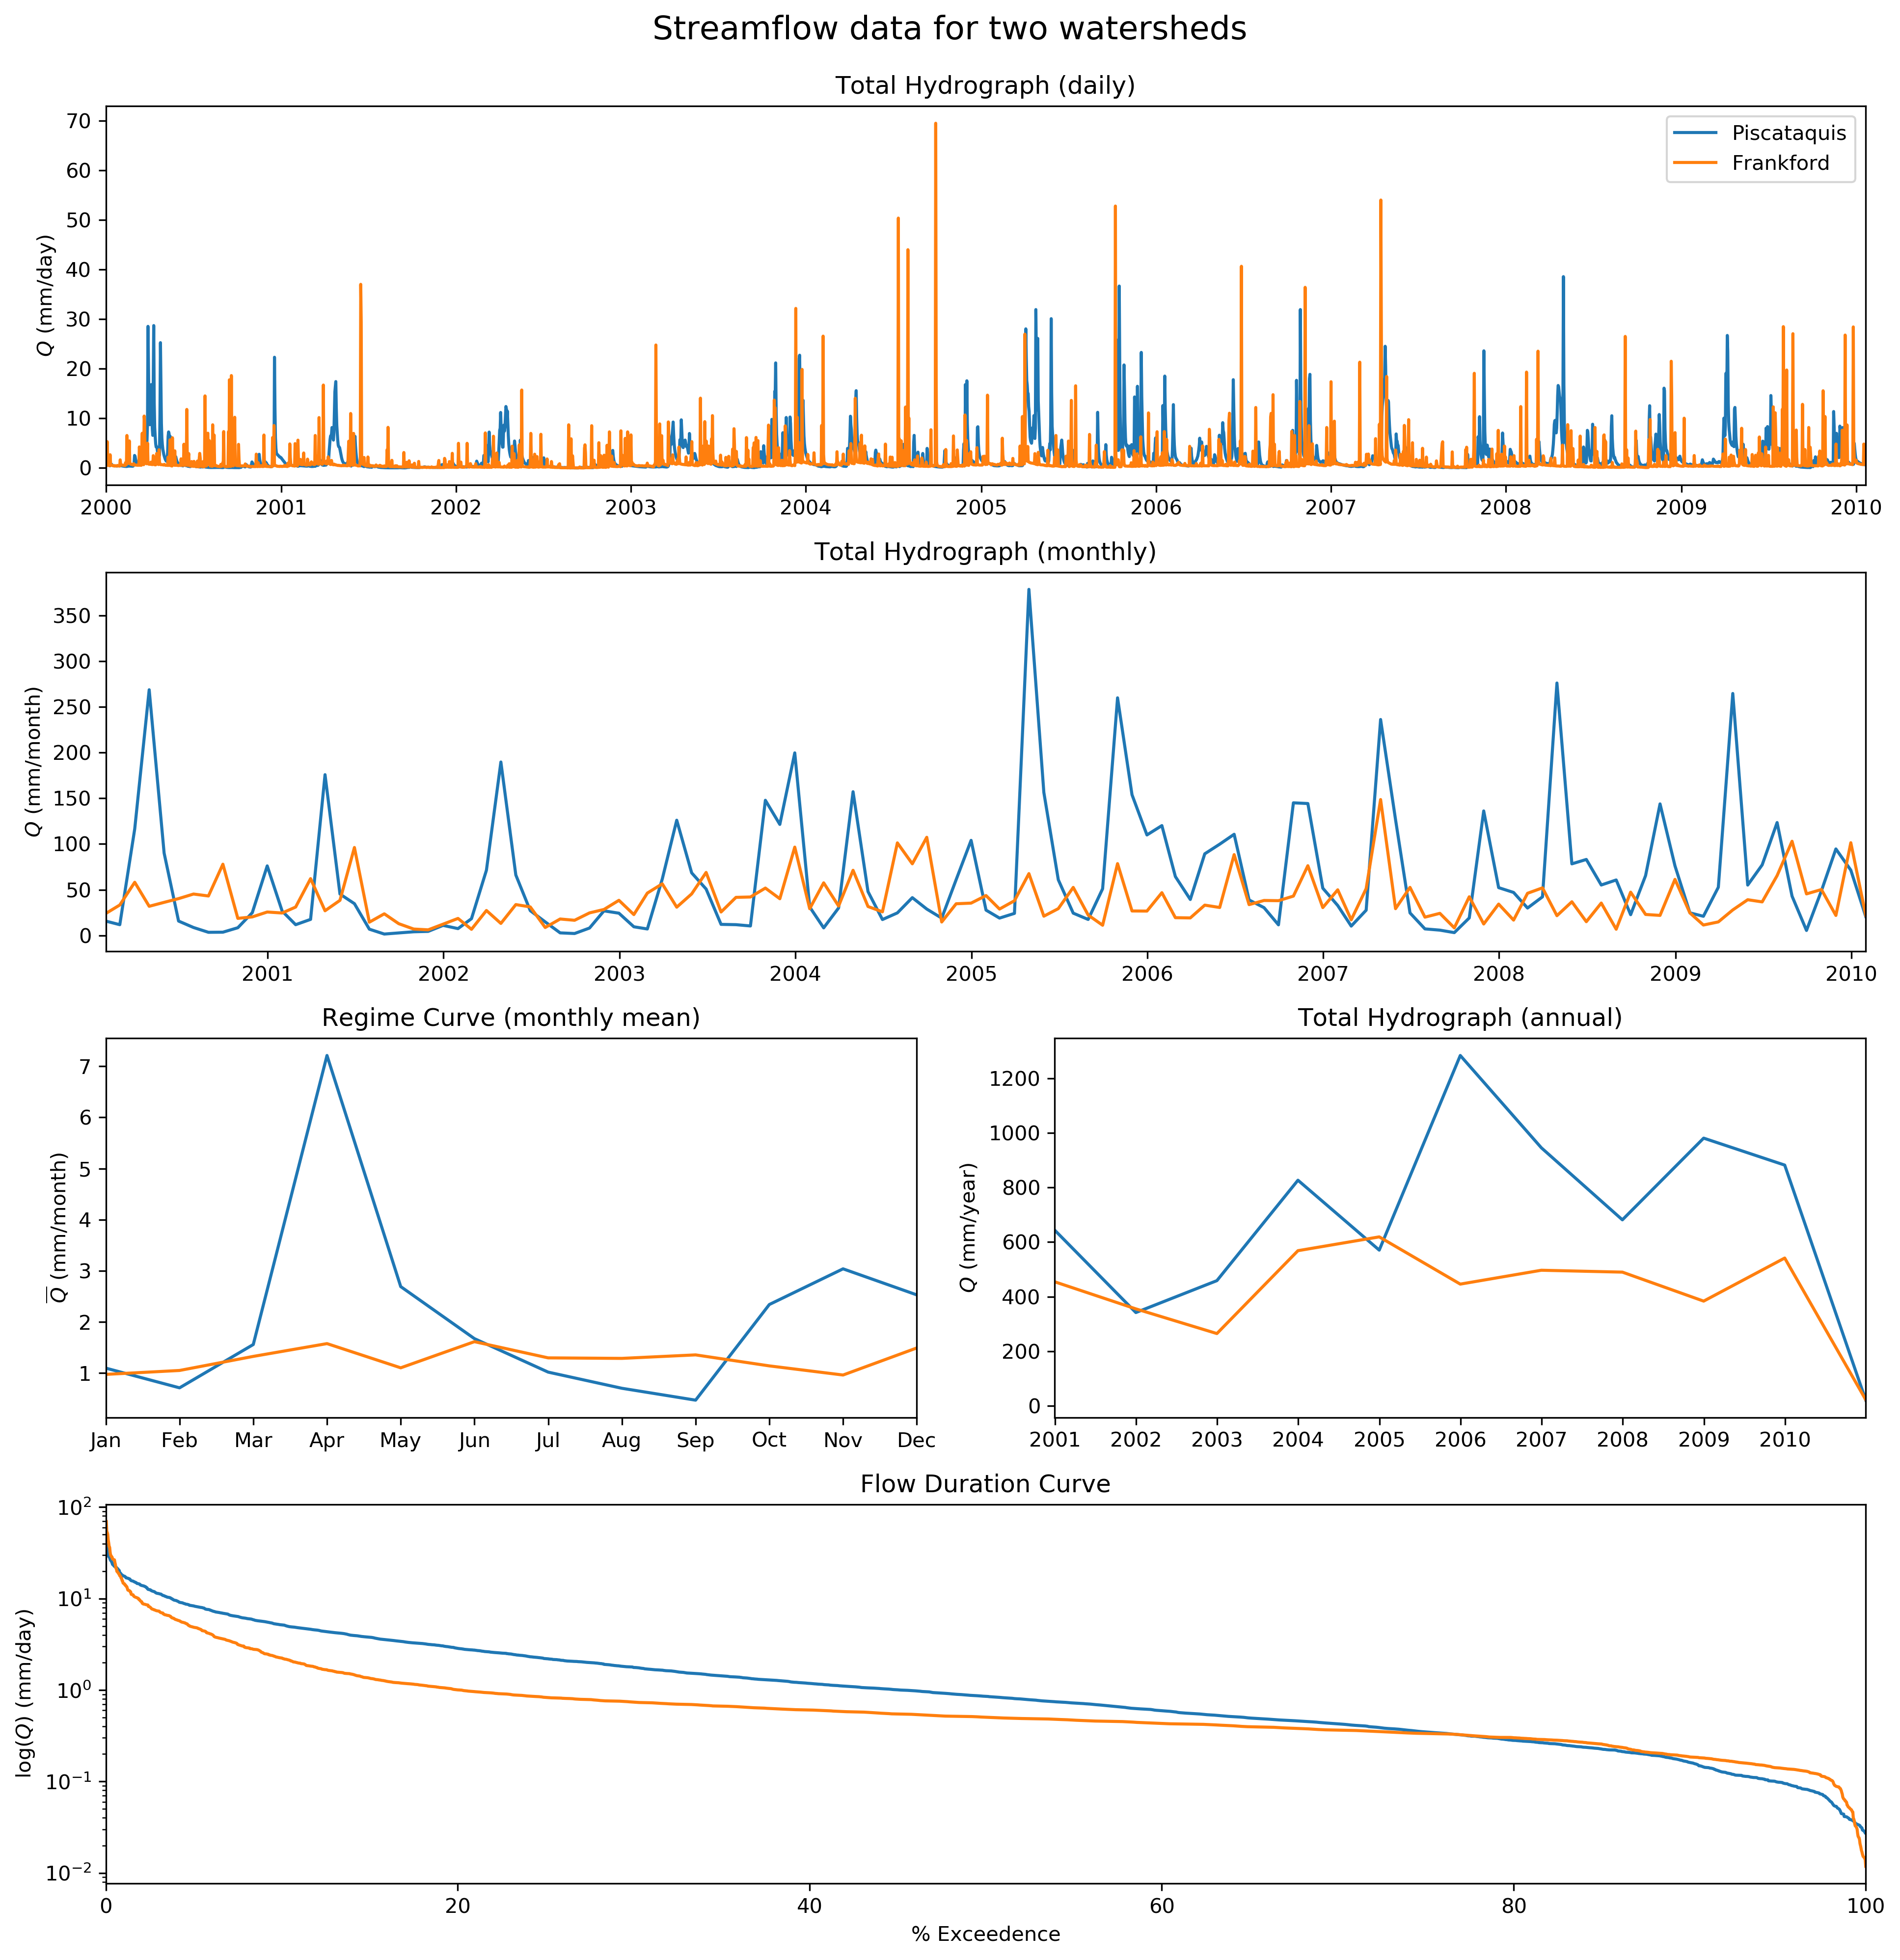

In [17]:
Q_daily = {'Piscataquis': (piscataquis_clm['Q (cms)'], piscataquis.drainage_area),
           'Frankford': (frankford_Q, frankford.drainage_area)}
plot.signatures(Q_daily=Q_daily,
                title='Streamflow data for two watersheds')